# Technical Stuff

#### Packages Import

In [1]:
import numpy as np
from typing import List
from tqdm import tqdm

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
from skimage import measure, filters, morphology
import scipy.cluster.hierarchy as hcluster

import warnings
warnings.filterwarnings('ignore')

In [5]:
""" Binary Image + cv2.Contour -> Image on the Screen. """
def show_contours( contours, img ):
    fig, ax = plt.subplots(figsize=(20, 10), dpi=120)
    ax.imshow(img, cmap=plt.cm.gray)
    for c in contours:
        if len(contours) > 1:
            ax.plot(c[:, 1], c[:, 0], linewidth=2)
        else:
            ax.plot(c[:, 1], c[:, 0], linewidth=2, color='red')
    ax.grid(False)

In [10]:
""" Extract the upper rim of the chosen contour. """
def contour2rim( target_contour ):
    d = {}
    for yx in target_contour:
        y, x = int(yx[0]), int(yx[1])
        if d.get(x) == None:
            d[x] = []
        d[x].append(y)
    for k,v in d.items():
        d[k] = min(v)
    rim = np.array([list(d.values()), list(d.keys())]).astype(int).T
    return rim

In [11]:
""" Draw the final mask. """
def rim2mask( bin, rim, HEIGHT=4 ):
    mask = np.zeros_like(bin)
    for i in rim:
        for j in range(HEIGHT):
            mask[i[0]-j, i[1]] = 1
    return mask

## Choose Frame

In [12]:
""" Pick one shape from the ones on the image. """
def the_chosen_shape(bin):
    app, cs, areas = create_contours(bin)
    lowest_contour = sorted(cs, key=lambda c: np.mean(c[:,0]))[-1]
    return lowest_contour

In [13]:
""" Check if the two shapes on a binary image are
on top of each other (True) or side by side (False). """
def good_separation(app, contours):

    j = 0
    old = (1.0 in app[:, j])
    hitpoint = True
    while j<app.shape[1]-1:
        j += 1
        new = (1.0 in app[:, j])
        if (old==True) and (new!=True):
            if hitpoint == True:
                hitpoint = False
            else:
                return False
        old = new
    return True

In [30]:
""" The main postprocessor pipeline. """
def postprocessor(bin, mask_height=4, display=False):

    """ Clean and create good contours. """
    app, contours, areas = create_contours( bin )
    num_shapes = len(contours)

    """ Determine the case. """
    chosen_contour = None
    if num_shapes == 1:
        app = lightsaber( app )
    elif num_shapes == 2:
        if good_separation(app, contours) == True:
            pass
        else:
            app = lightsaber( app )
            app = bridge( app, contours )
    elif num_shapes == 3:
        pass
    elif num_shapes == 4:
        app = bridge( app, contours )
    else:
        return bin
    chosen_contour = the_chosen_shape(app)

    """ Create the mask. """
    rim = contour2rim( chosen_contour )
    mask = rim2mask( app, rim, mask_height )
    canvas = overlap( app, mask )
    canvas = np.transpose(canvas, (1,0,2))


    if display:
        with plt.style.context('dark_background'):
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10), dpi=130)
            
            ax1.imshow(bin, cmap=plt.cm.gray)
            ax1.title.set_text(f'{num_shapes}')
            # [ax1.plot(contour[:, 1], contour[:, 0], linewidth=2, c=['crimson', 'cyan', 'orange', 'lightgreen'][i%4]) for i, contour in enumerate(contours)]
            
            ax2.imshow(app, cmap=plt.cm.gray)
            if type(chosen_contour) == np.ndarray:
                ax2.plot(chosen_contour[:, 1], chosen_contour[:, 0], linewidth=2, c='lightgreen')

            ax3.imshow(canvas, cmap='viridis')

    return canvas

### Cleaning

In [31]:
def create_contours(bin, display=False, RATIO_TH=9):


    """ Padding. """
    bin[:,:3] = 0.0
    bin[:,-3:] = 0.0

    """ Finding all contours. """
    contours = []
    areas = []
    for contour in measure.find_contours( bin ):
        c = np.expand_dims(contour.astype(np.float32), 1)
        c = cv2.UMat(c)
        area = cv2.contourArea(c)
        contours.append(contour)
        areas.append(area)

    """ If the image is empty. """
    if len(contours) == 0:
        return bin, [], []

    maximum = max(areas)
    if maximum < 500:
        bin = morphology.remove_small_objects(bin.astype('bool'), min_size=(maximum+1)).astype('float')
        return bin, [], []

    """ Finding good contours. """
    good_contours = []
    good_areas = []
    bad_areas = []

    for c, a in zip(contours, areas):
        if (maximum / a) < RATIO_TH:
            good_contours.append(c)
            good_areas.append(a)
        else:
            bad_areas.append(a)

    """ Removing small objects. """
    if len(bad_areas) > 0:
        TH = max(bad_areas)+1
        bin = morphology.remove_small_objects(bin.astype('bool'), min_size=TH).astype('float')
        bin = morphology.remove_small_holes(bin.astype('bool'), area_threshold=TH).astype('float')
        

    if display:
        show_contours(good_contours, good_areas)

    return bin, good_contours, good_areas

### The Bridge

In [33]:
def bridge(
               bin,                             # Binary image
               contours,                        # Shapes contours
               METHOD       = 'cv2.TM_CCOEFF',  # MatchTemplate method
               THRESH       = 1.5,              # Clustering proximity
               KP_NUMBER    = 150,              # Number of keypoints to find 
               REACH        = 15,               # How far the bridge swings on "land"
               BRIDGE_WIDTH = 3,                # Bridge's "width"
               v            = False,            # Verbosity
               display      = False             # Draw pictures
              ):

    app = bin.copy()

    templates = []
    for fn in ['tmp11.jpg']:
        img = Image.open( f'/content/drive/MyDrive/Projects/Thesis/Data/{fn}' )
        img.load()
        img = np.array(img)
        img[img < 128] = 0.0
        img[img > 128] = 1.0
        templates.append((img, np.fliplr(img)))
    plt_offset = templates[0][0].shape[0]//2


    """ Keypoints. """
    kp_total = np.array([0, 0])
    for template in templates:
        tmp1, tmp2 = template
        res_left = cv2.matchTemplate( app.astype(np.uint8), tmp1.astype(np.uint8), eval(METHOD) )
        res_right = cv2.matchTemplate( app.astype(np.uint8), tmp2.astype(np.uint8), eval(METHOD) )
        left_kp = top_keypoints(res_left, KP_NUMBER)
        right_kp = top_keypoints(res_right, KP_NUMBER)
        new_kp = np.vstack((left_kp, right_kp))
        kp_total = np.vstack( (kp_total, new_kp) )
    keypoints = kp_total[1:, :]

    """ Clusters. """
    clusters = hcluster.fclusterdata(keypoints, THRESH, criterion="distance")
    centroids = []
    for cli in np.unique(clusters):
        cluster = keypoints[clusters == cli]
        centroid = (cluster[:,0].mean(), cluster[:,1].mean())
        centroids.append(centroid)
    centroids = np.array(centroids)

    meanline = 0
    for contour in contours:
        meanline += np.mean(np.unique(contour[:,1]))
    meanline /= len(contours)

    radius = 2 * np.min([abs(c[1]-meanline) for c in centroids])
    radius = max(radius, 50)

    good_centroids = np.array([c for c in centroids if abs(c[1]-meanline) <= radius])
    good_centroids = np.array(sorted(good_centroids, key=lambda yx: yx[0]))
    RPs = good_centroids[-2:]

    start, finish = sorted(RPs, key=lambda yx: yx[1])
    xbridge = range(int(start[1]), int(finish[1]))
    ybridge = [start[0] for x in xbridge]


    for xi, yi in zip(xbridge, ybridge):
        app[int(yi-BRIDGE_WIDTH):int(yi+BRIDGE_WIDTH+1)+plt_offset, int(xi)+plt_offset] = 1.0


    if display:
        with plt.style.context('dark_background'):

            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 17), dpi=120)
            ax1.imshow( bin, cmap='gray' )

            """ The process. """
            ax2.imshow(app, cmap='gray') # Shape
            ax2.scatter(centroids[:,1]+plt_offset, centroids[:,0]+plt_offset, c='red')
            ax2.scatter(good_centroids[:,1]+plt_offset, good_centroids[:,0]+plt_offset, c='lightgreen')
            ax2.scatter(RPs[:,1]+plt_offset, RPs[:,0]+plt_offset, c='purple', s=100)

            HEIGHT = bin.shape[0]
            ax2.plot( [meanline+plt_offset for _ in range(HEIGHT)], [y+plt_offset for y in range(HEIGHT)], c='lightgreen' )
            ax2.plot( [meanline+plt_offset-radius for _ in range(HEIGHT)], [y+plt_offset for y in range(HEIGHT)], c='green' )
            ax2.plot( [meanline+plt_offset+radius for _ in range(HEIGHT)], [y+plt_offset for y in range(HEIGHT)], c='green' )

            """ The result. """
            ax3.imshow(app, cmap='gray') # Shape

    return app

### The Lightsaber

In [34]:
def top_keypoints( img, KP_NUMBER ):
    app = img.copy()
    result = np.zeros((KP_NUMBER, 2))
    for i in range(KP_NUMBER):
        xy = np.where( app == np.max(app) )
        x = xy[0][0]
        y = xy[1][0]
        app[x, y] = 0.0
        result[i][0] = x
        result[i][1] = y
    return result


def estimate_keypoint(iyx, app, XRANGE, YRANGE, plt_offset, mod=1.5, looking_for='left'):
    i = int(iyx[0]); y = int(iyx[1])+plt_offset; x = int(iyx[2])+plt_offset;
    total = 0
    total += np.sum(app[y-YRANGE:y, x])
    total += np.sum(app[y:y+YRANGE, x])
    if looking_for=='left':
        total -= mod*np.sum(app[y, x-XRANGE:x])
        total += mod*np.sum(app[y, x:x+XRANGE])
    elif looking_for=='right':
        total += mod*np.sum(app[y, x-XRANGE:x])
        total -= mod*np.sum(app[y, x:x+XRANGE])
    return total

In [35]:
def lightsaber(
               bin,                             # Binary image
               METHOD       = 'cv2.TM_CCOEFF',  # MatchTemplate method
               THRESH       = 1.5,              # Clustering proximity
               KP_NUMBER    = 150,              # Number of keypoints to find 
               YRANGE       = 30,               # Parameter for the competition
               XRANGE       = 15,               # Parameter for the competition
               REACH        = 10,               # How far the saber swings 
               LAZER_RADIUS = 2,                # Saber's width
               v            = False,            # Verbosity
               display      = False             # Draw pictures
              ):

    app = bin.copy()

    templates = []
    for fn in ['tmp10.jpg']:
        img = Image.open( f'/content/drive/MyDrive/Projects/Thesis/Data/{fn}' )
        img.load()
        img = np.array(img)
        img[img < 128] = 0.0
        img[img > 128] = 1.0
        templates.append((img, np.fliplr(img)))
    plt_offset = templates[0][0].shape[0]//2


    kp_total = np.array([0, 0])
    for template in templates:
        tmp1, tmp2 = template
        res_left = cv2.matchTemplate( app.astype(np.uint8), tmp1.astype(np.uint8), eval(METHOD) )
        res_right = cv2.matchTemplate( app.astype(np.uint8), tmp2.astype(np.uint8), eval(METHOD) )
        left_kp = top_keypoints(res_left, KP_NUMBER)
        right_kp = top_keypoints(res_right, KP_NUMBER)
        new_kp = np.vstack((left_kp, right_kp))
        kp_total = np.vstack( (kp_total, new_kp) )
    kp_total = kp_total[1:, :]


    """ Filtering. """
    tmp = []
    for yx in kp_total:
        y = int(yx[0])
        x = int(yx[1])
        cond = (sum(app[y-YRANGE:y, x]) >= YRANGE//2) and (sum(app[y:y+YRANGE, x]) >= YRANGE//2)
        if cond:
            tmp.append(yx)
    keypoints = np.array(tmp)

    if len(keypoints) < 2:
        if v:
            print('Nothing to cut. Abandon.')
        return bin

    """ Clustering & Centroids. """
    clusters = hcluster.fclusterdata(keypoints, THRESH, criterion="distance")
    centroids = []
    for cli in np.unique(clusters):
        cluster = keypoints[clusters == cli]
        centroid = (cluster[:,0].mean(), cluster[:,1].mean())
        centroids.append(centroid)
    centroids = np.array(centroids)

    """ Competitions. """
    RPs = []
    iyxs = np.array([(i, c[0], c[1]) for i, c in enumerate(centroids)])
    for side in ['left', 'right']:
        ranking = []
        for iyx in iyxs:
            score = estimate_keypoint(iyx, app, XRANGE, YRANGE, plt_offset, looking_for=side)
            ranking.append((iyx, score))
        ranking = sorted(ranking, key=lambda iyxscore: iyxscore[-1], reverse=True )
        RPs.append(ranking[0][0])

        if v:
            print(f'Competition: {side}')
            for place, (iyx, score) in enumerate(ranking, 1):
                print( f'{place}.\t{iyx[0]}\t{score} pts.' )

    RP_LEFT, RP_RIGHT = RPs
    if v:
        print(f'Reference point LEFT: {RP_LEFT[0]}')
        print(f'Reference point RIGHT: {RP_RIGHT[0]}')


    """ Lightsaber in action. """
    rxs = [RP_LEFT[2]-REACH, RP_RIGHT[2]+REACH]
    rys = [RP_LEFT[1], RP_RIGHT[1]]
    theta = np.polyfit(rxs, rys, deg=1)
    line = np.poly1d(theta)
    xsaber = np.array( range(*[int(i) for i in sorted(rxs)]) )
    ysaber = np.array( [line(x) for x in xsaber] )
    for xi, yi in zip(xsaber, ysaber):
        app[int(yi-LAZER_RADIUS):int(yi+LAZER_RADIUS+1)+1*plt_offset, int(xi)+plt_offset] = 0.0


    if display:
        with plt.style.context('dark_background'):

            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 17), dpi=120)
            ax1.imshow( bin, cmap='gray' )

            """ The process. """
            ax2.imshow(bin, cmap='gray') # Shape

            """ Centroids. """
            centroids_colors = [['orange', 'gray', 'lightgreen', 'cyan', 'yellow'][(i-1)%5] for i in range(len(centroids))]
            ax2.scatter( centroids[:,1]+plt_offset, centroids[:,0]+plt_offset, c=centroids_colors, s=50 ) 
            for iyx in iyxs:
                ax2.text(x=iyx[2]+plt_offset//2, y=iyx[1]-5, s=str(iyx[0]), c='red')
            ax2.scatter( RP_LEFT[2]+plt_offset, RP_LEFT[1]+plt_offset, c='pink', s=100 )
            ax2.scatter( RP_RIGHT[2]+plt_offset, RP_RIGHT[1]+plt_offset, c='purple', s=100 )
            ax2.plot( xsaber+plt_offset, ysaber+plt_offset, c='red' )

            """ The result. """
            ax3.imshow(app, cmap='gray') 

    return app

# The Results

31it [00:07,  3.90it/s]


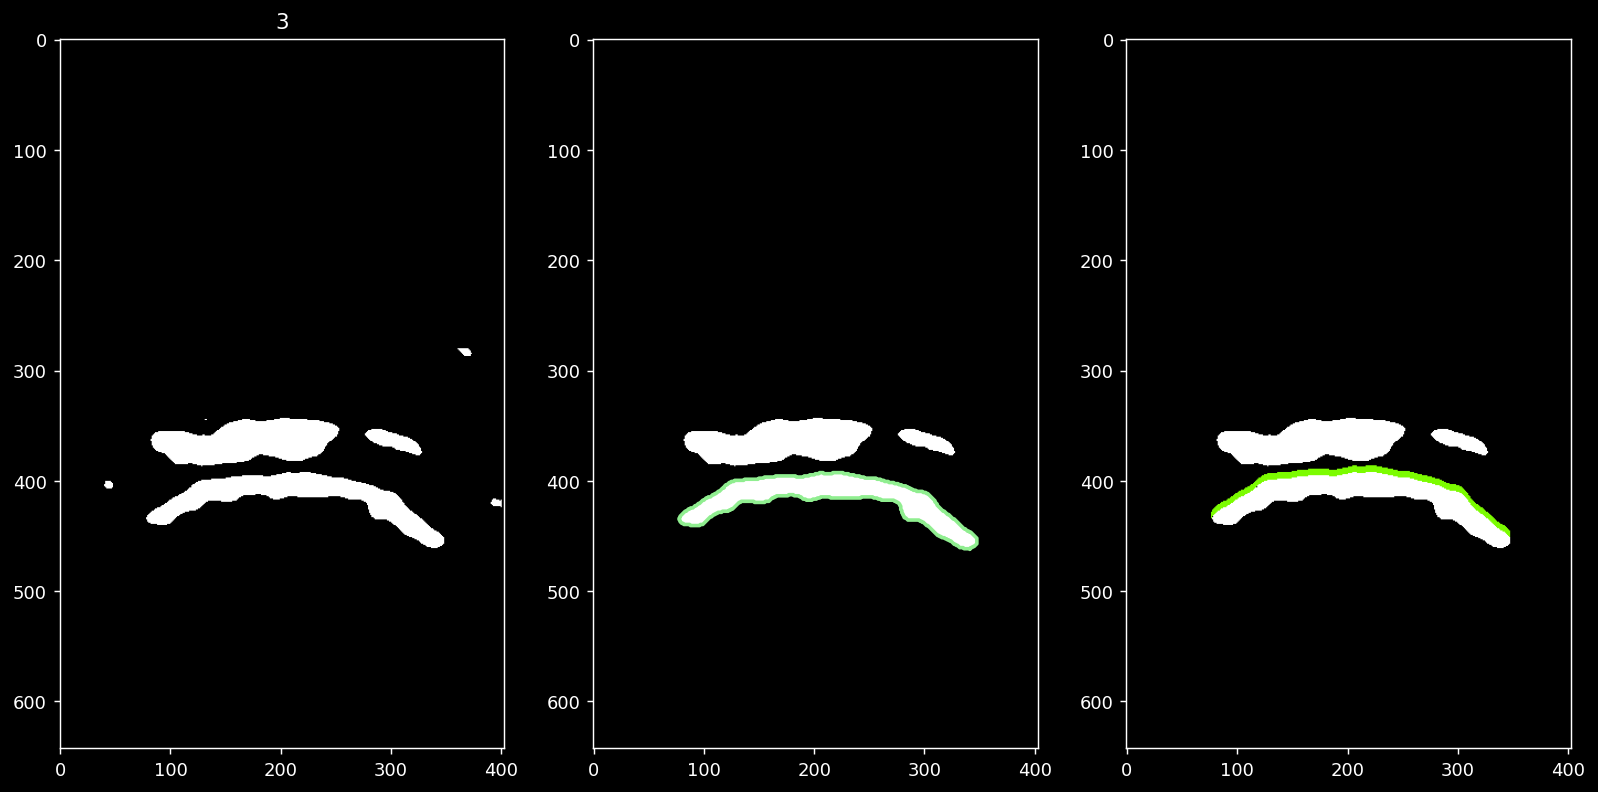

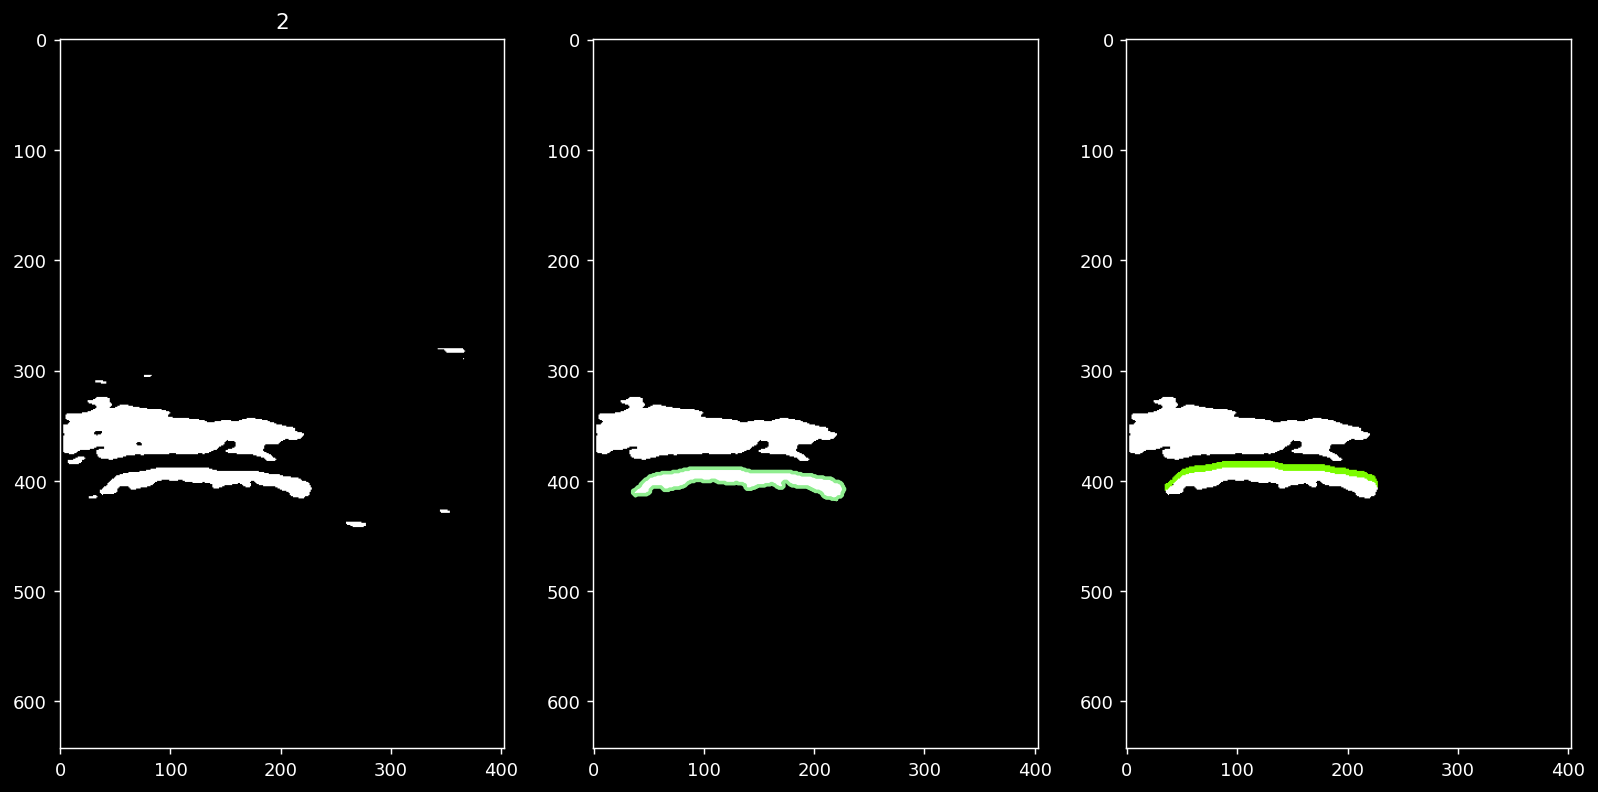

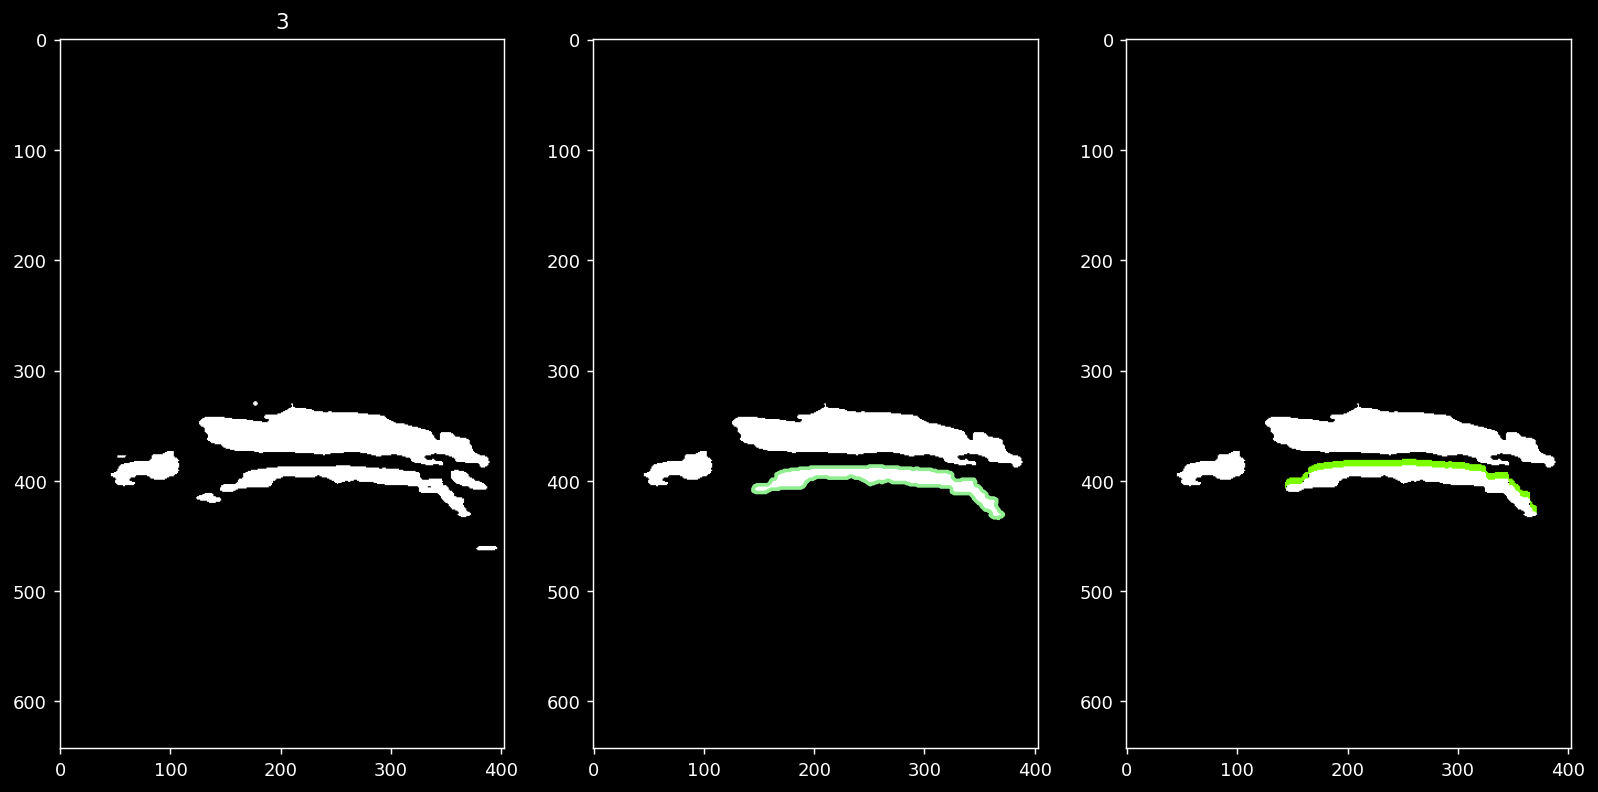

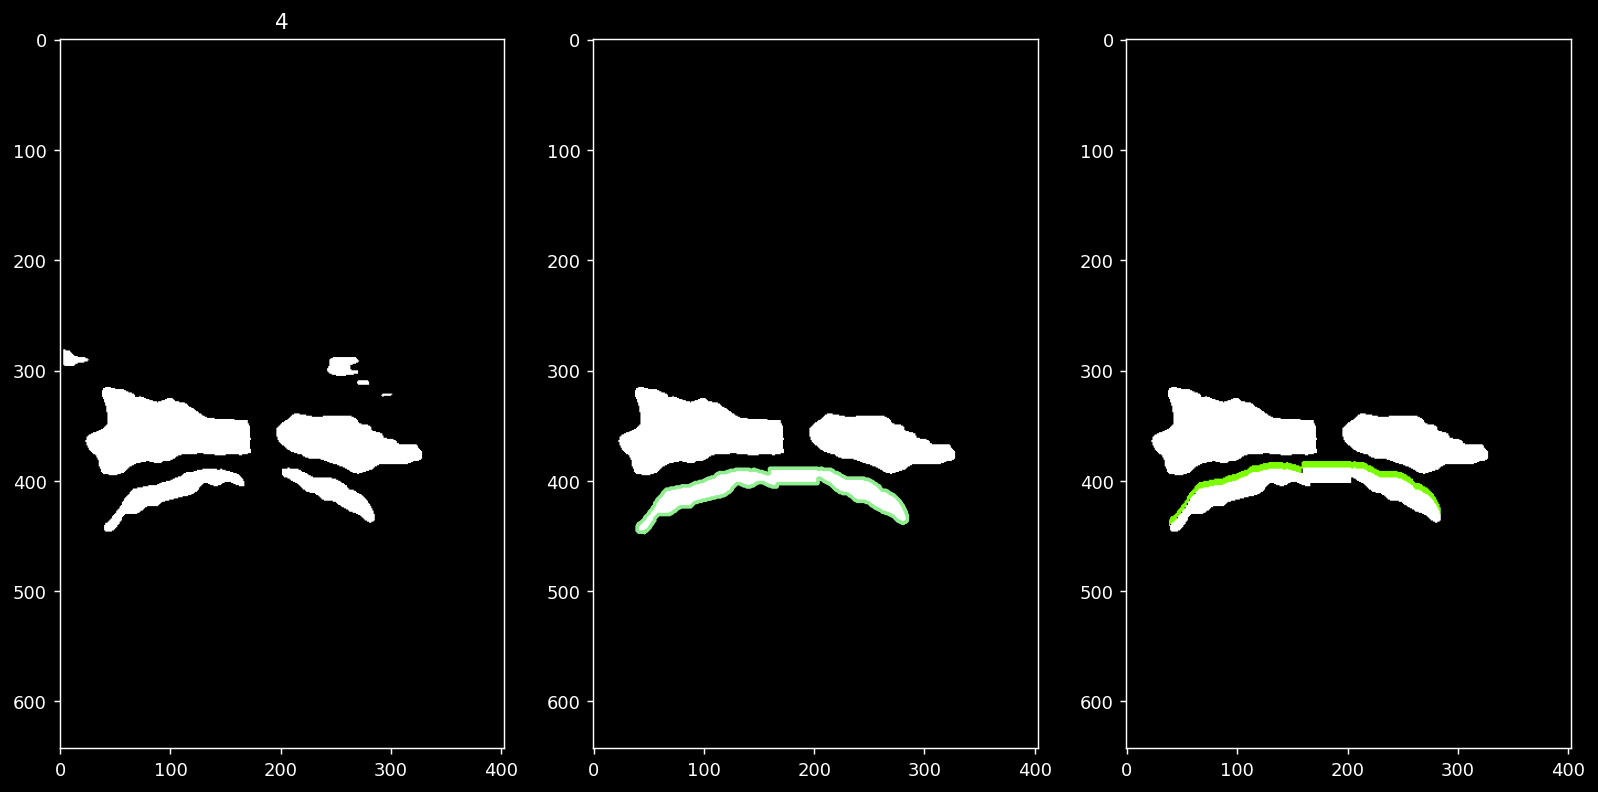

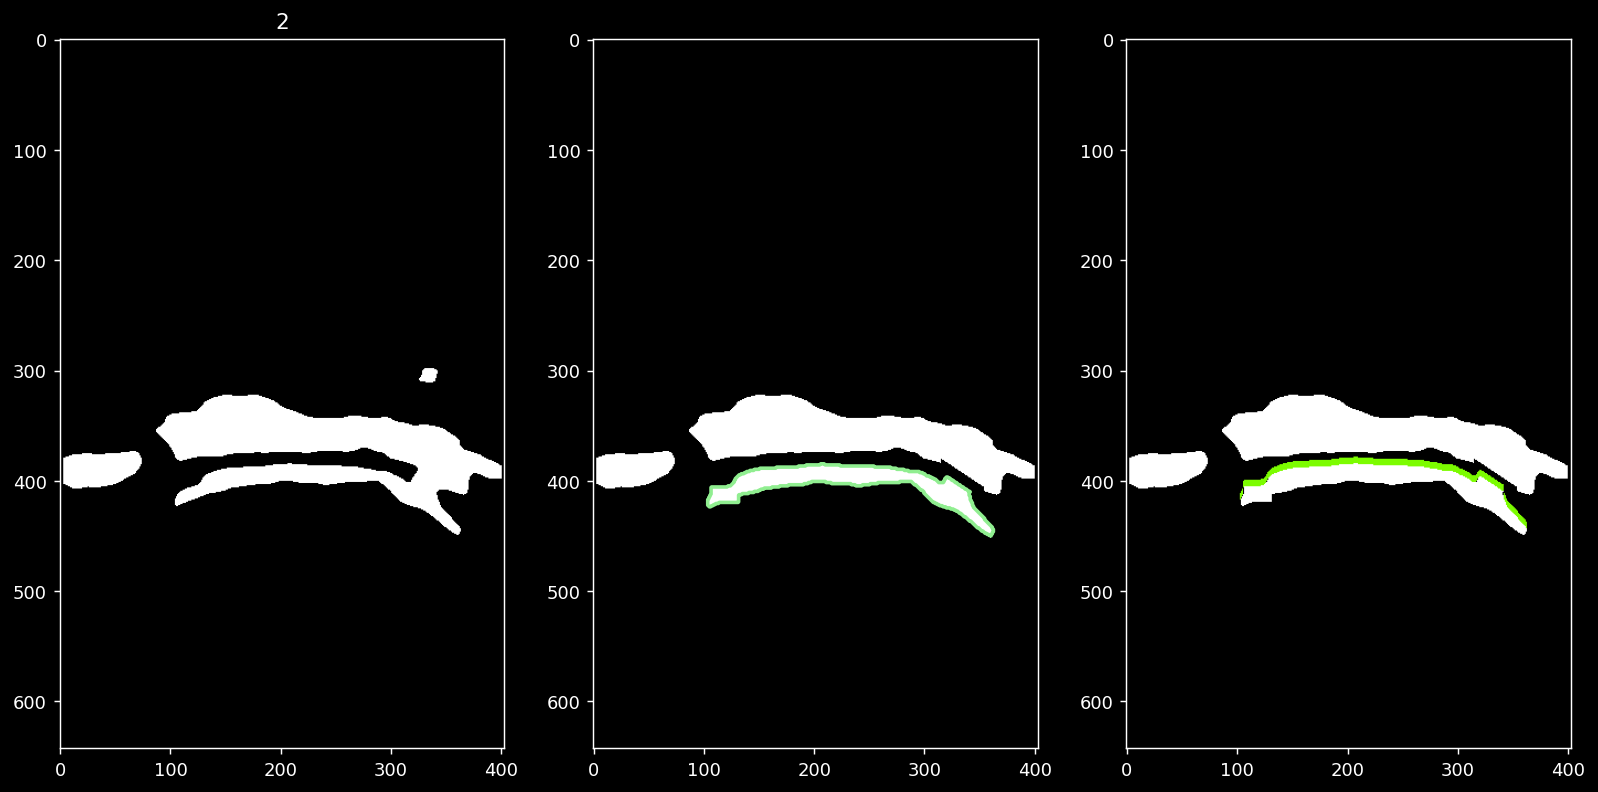

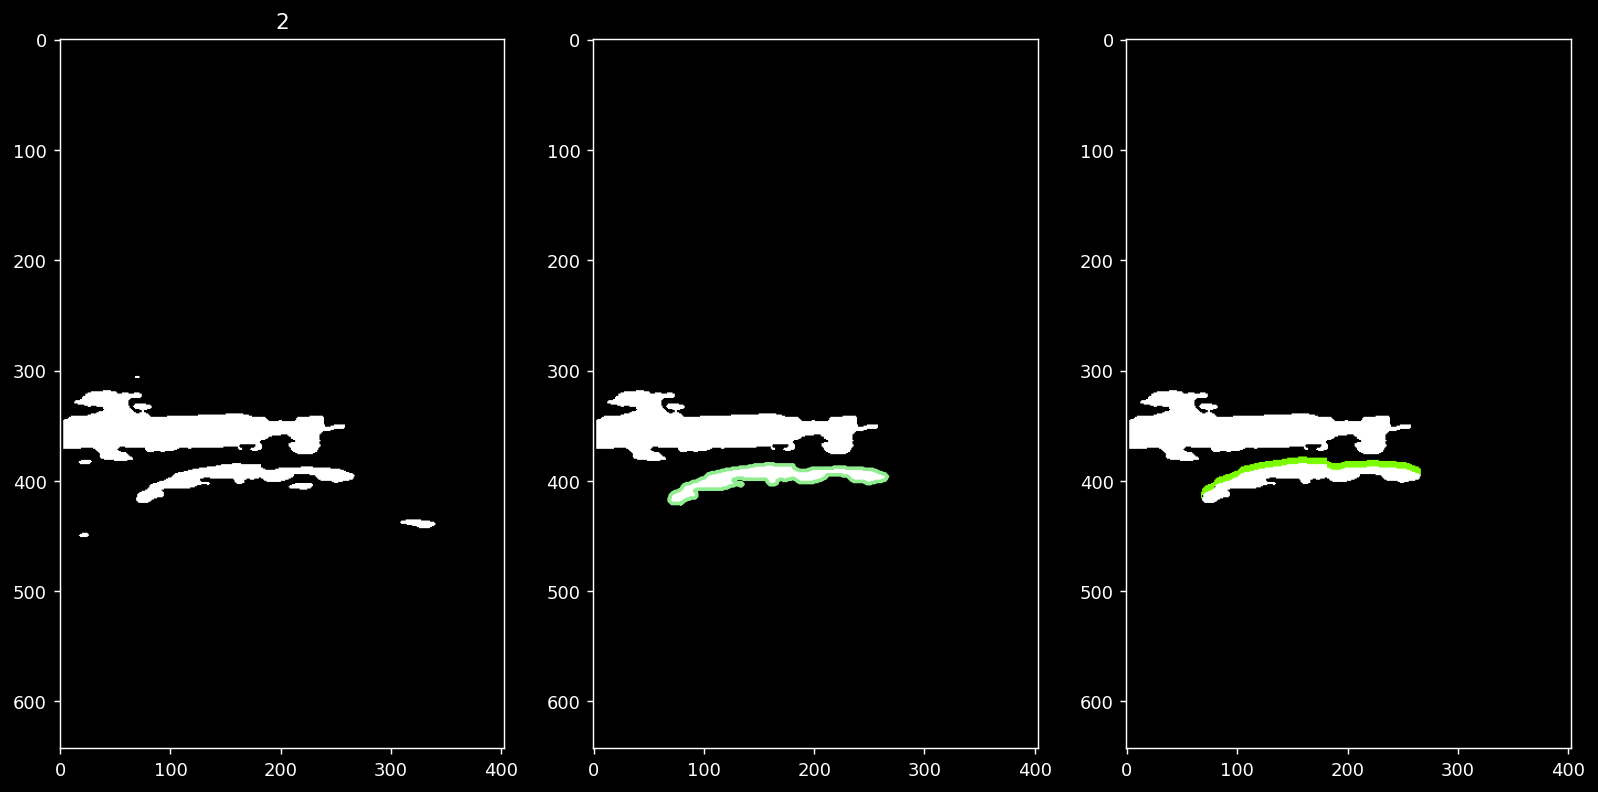

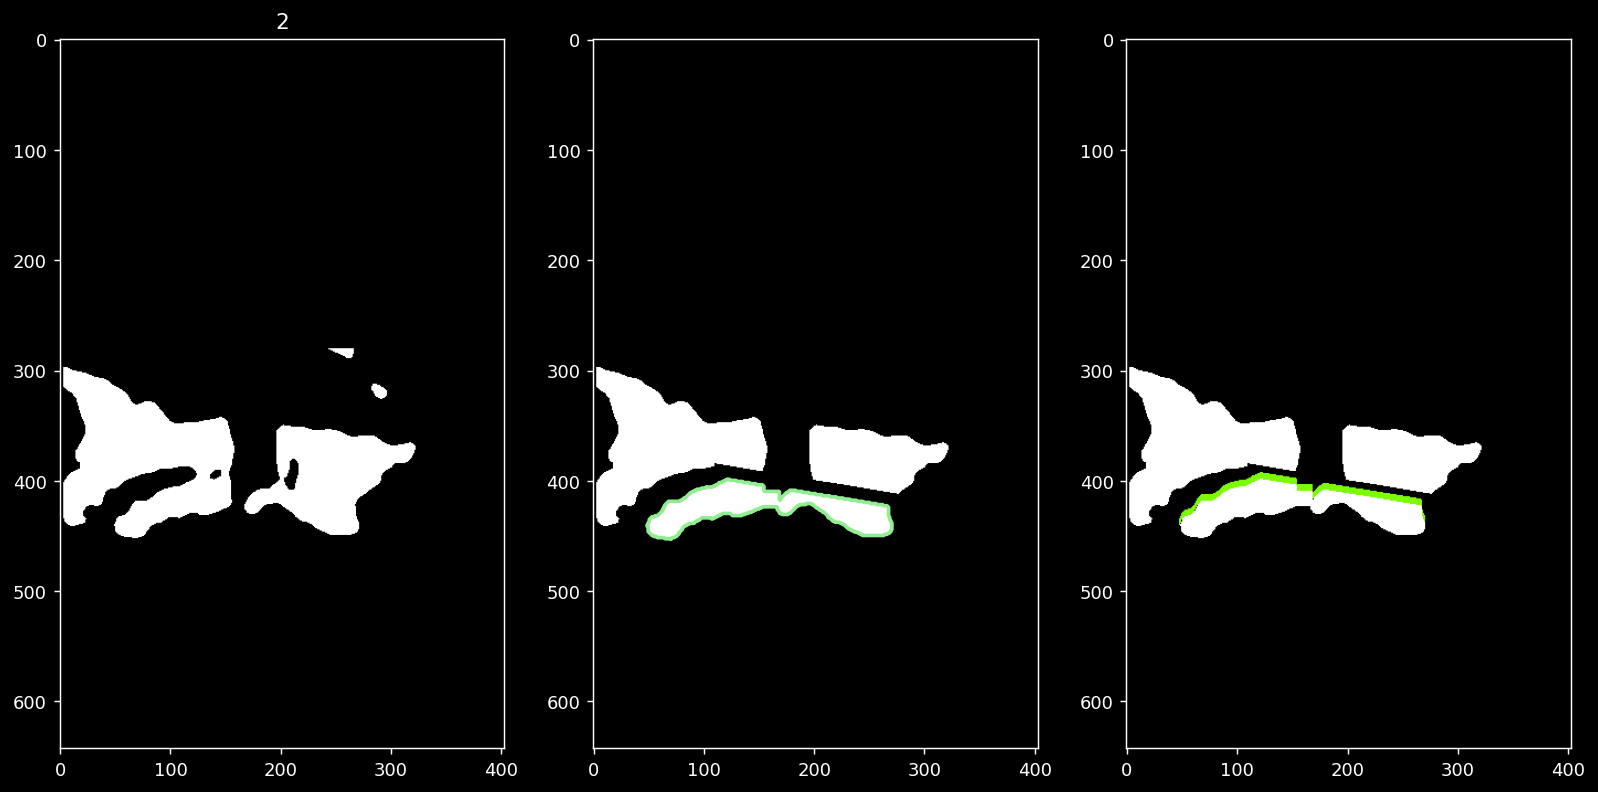

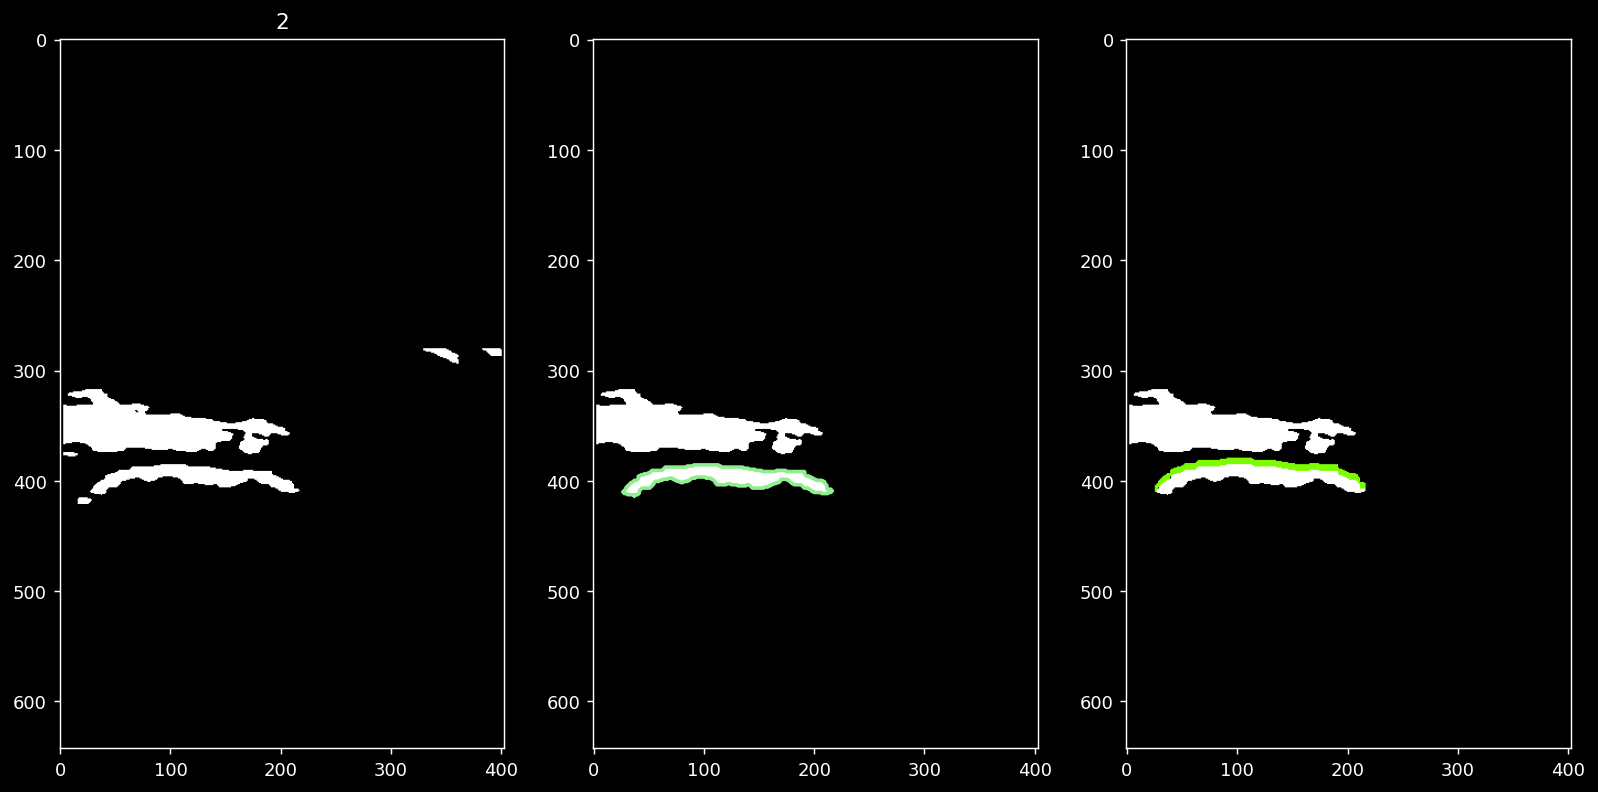

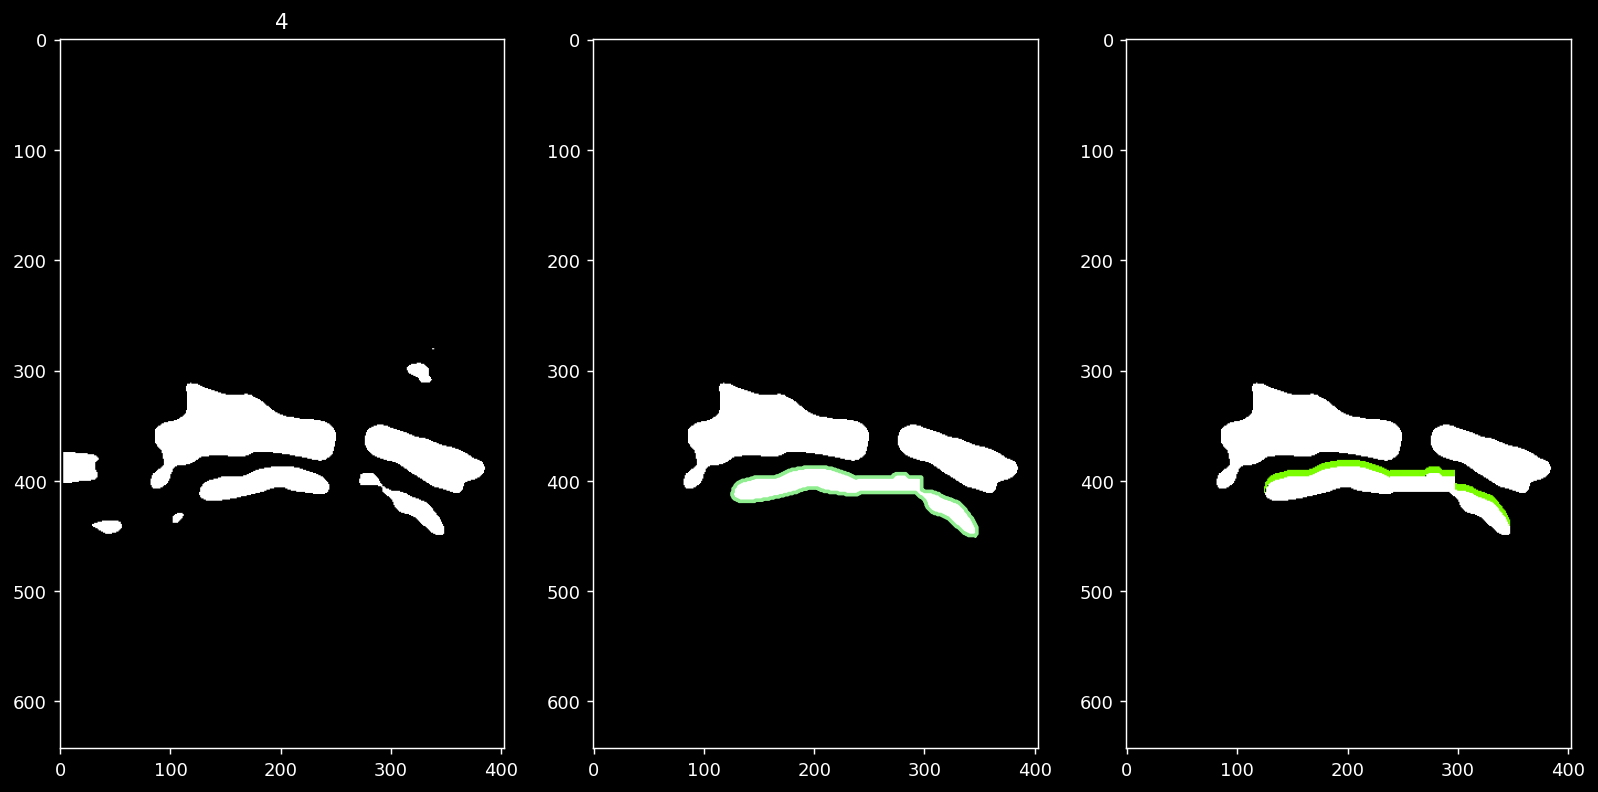

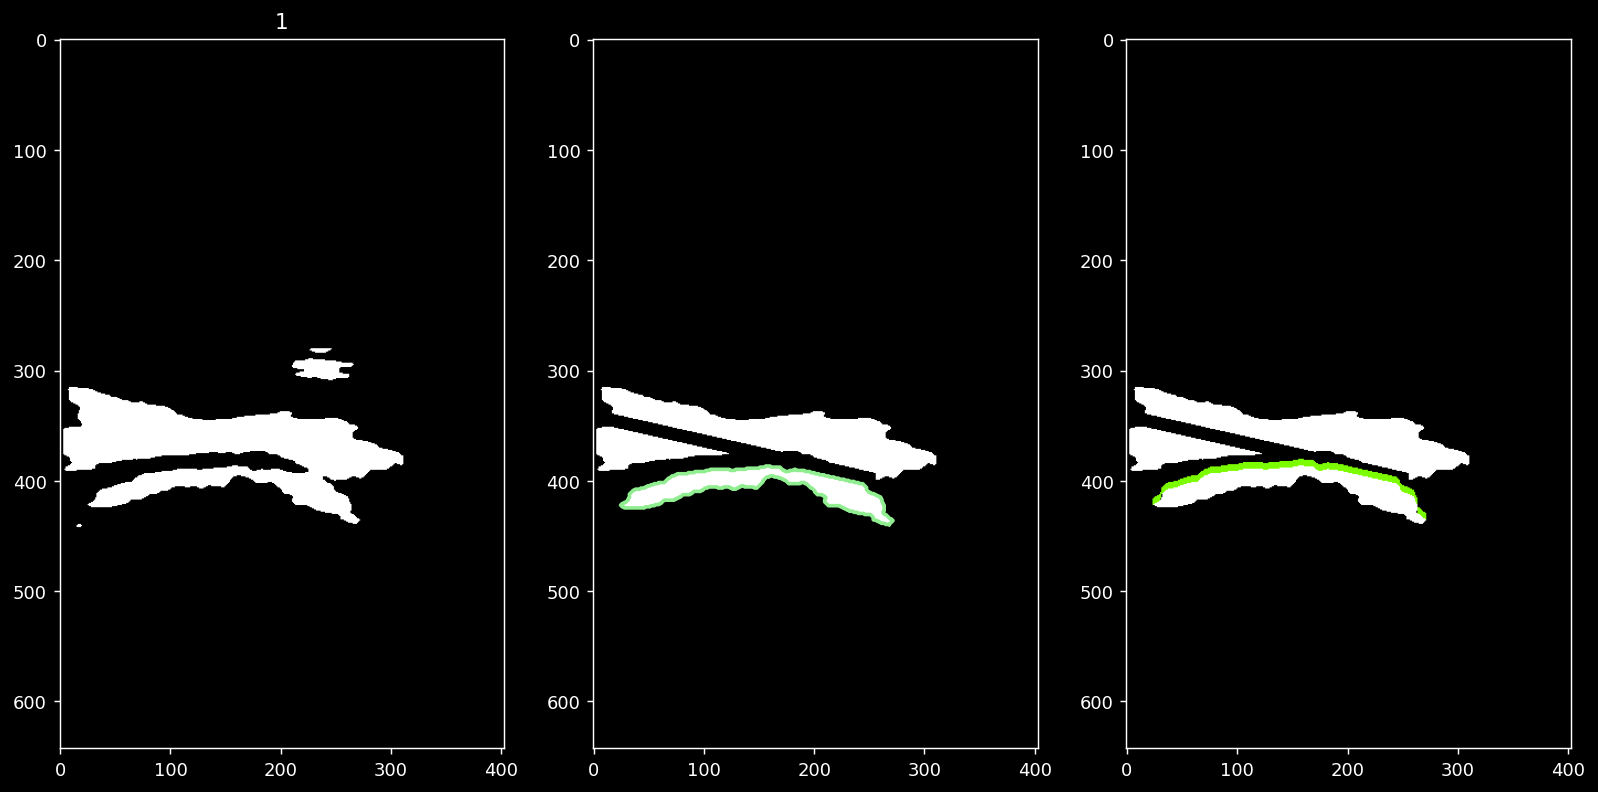

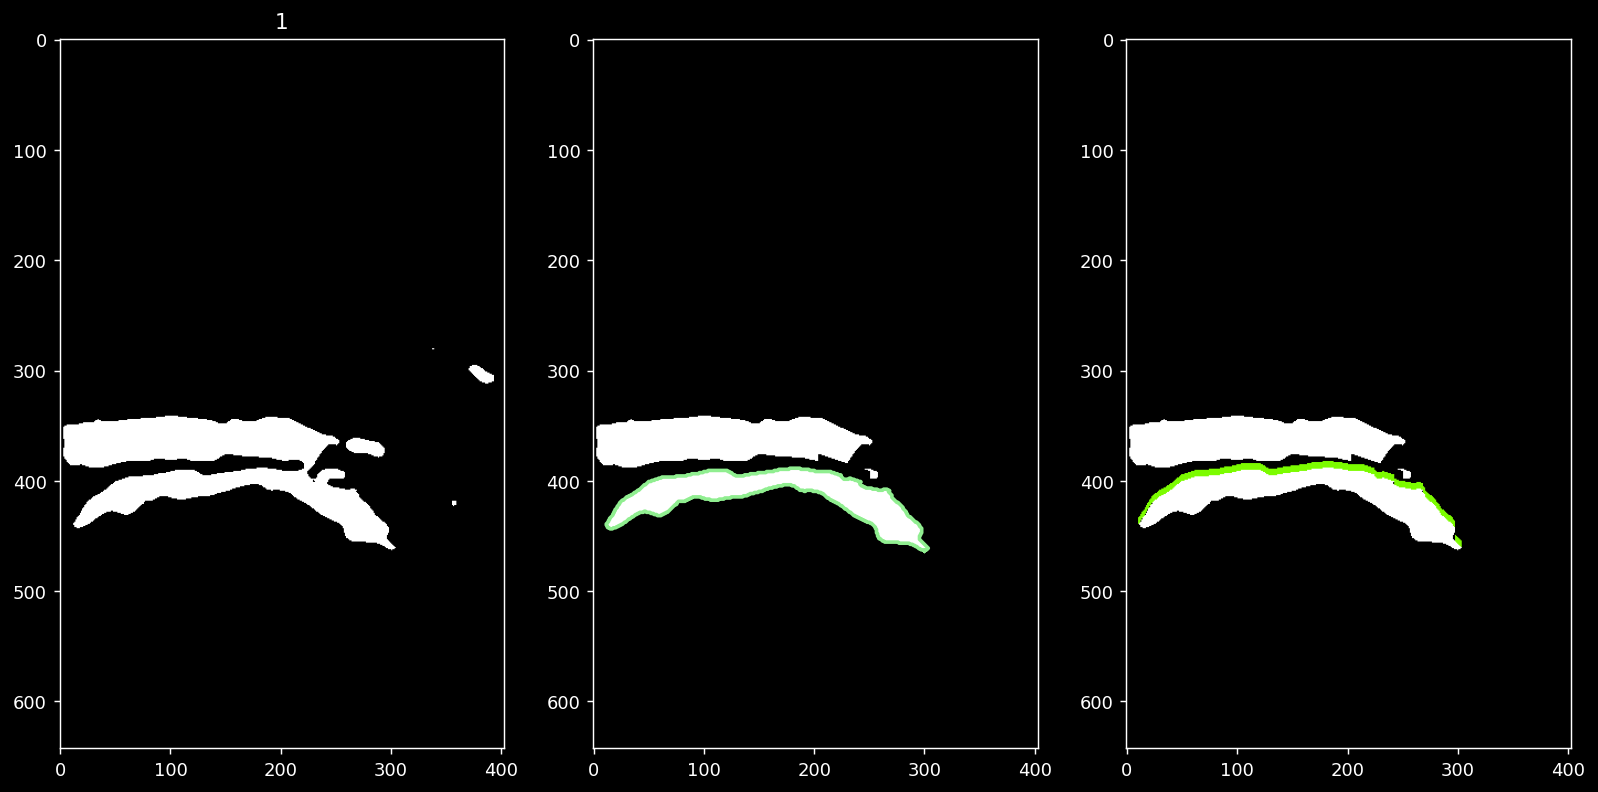

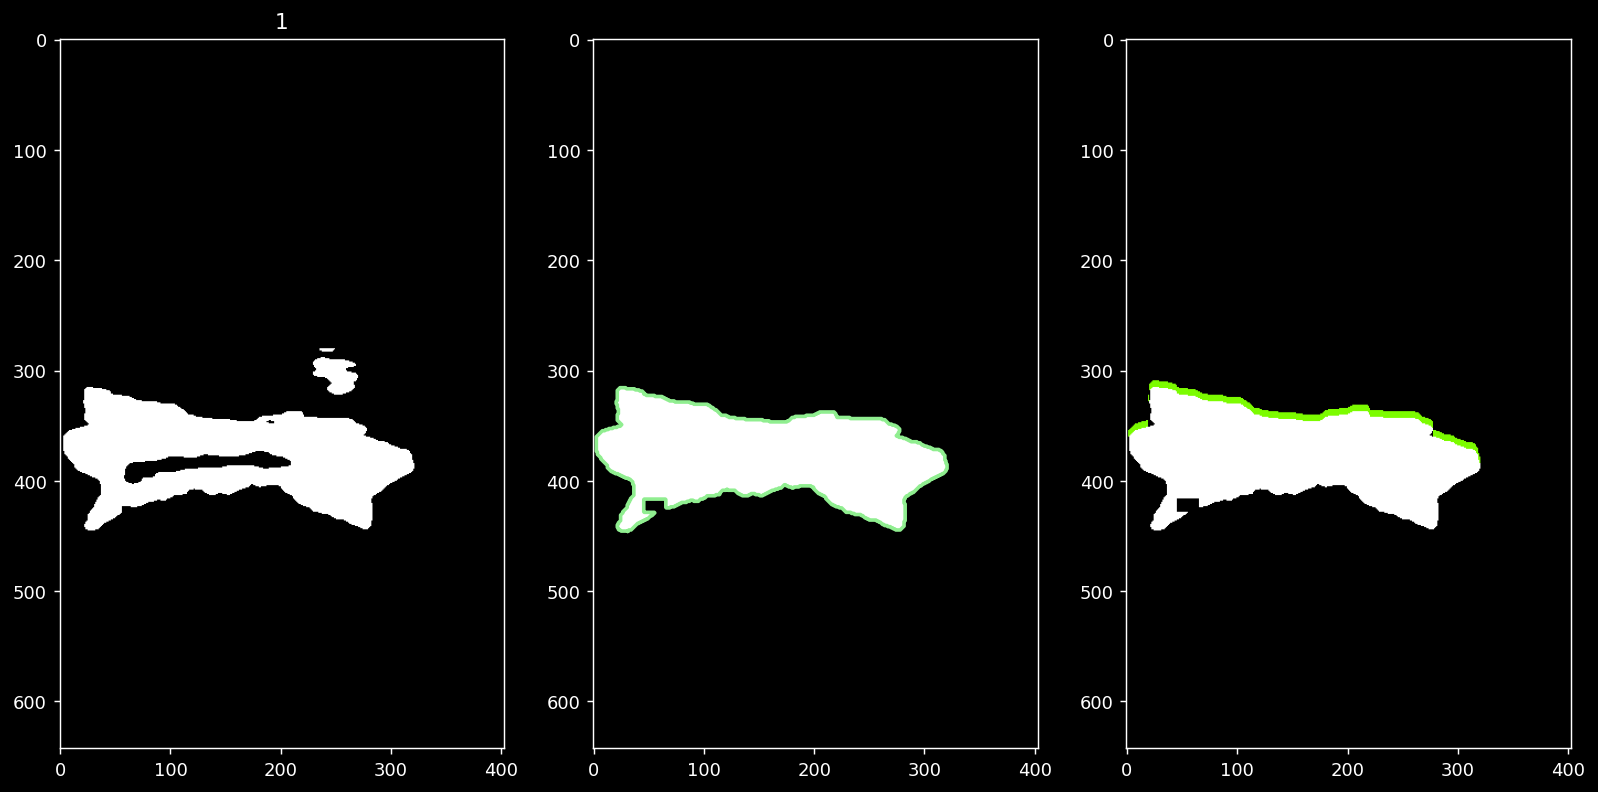

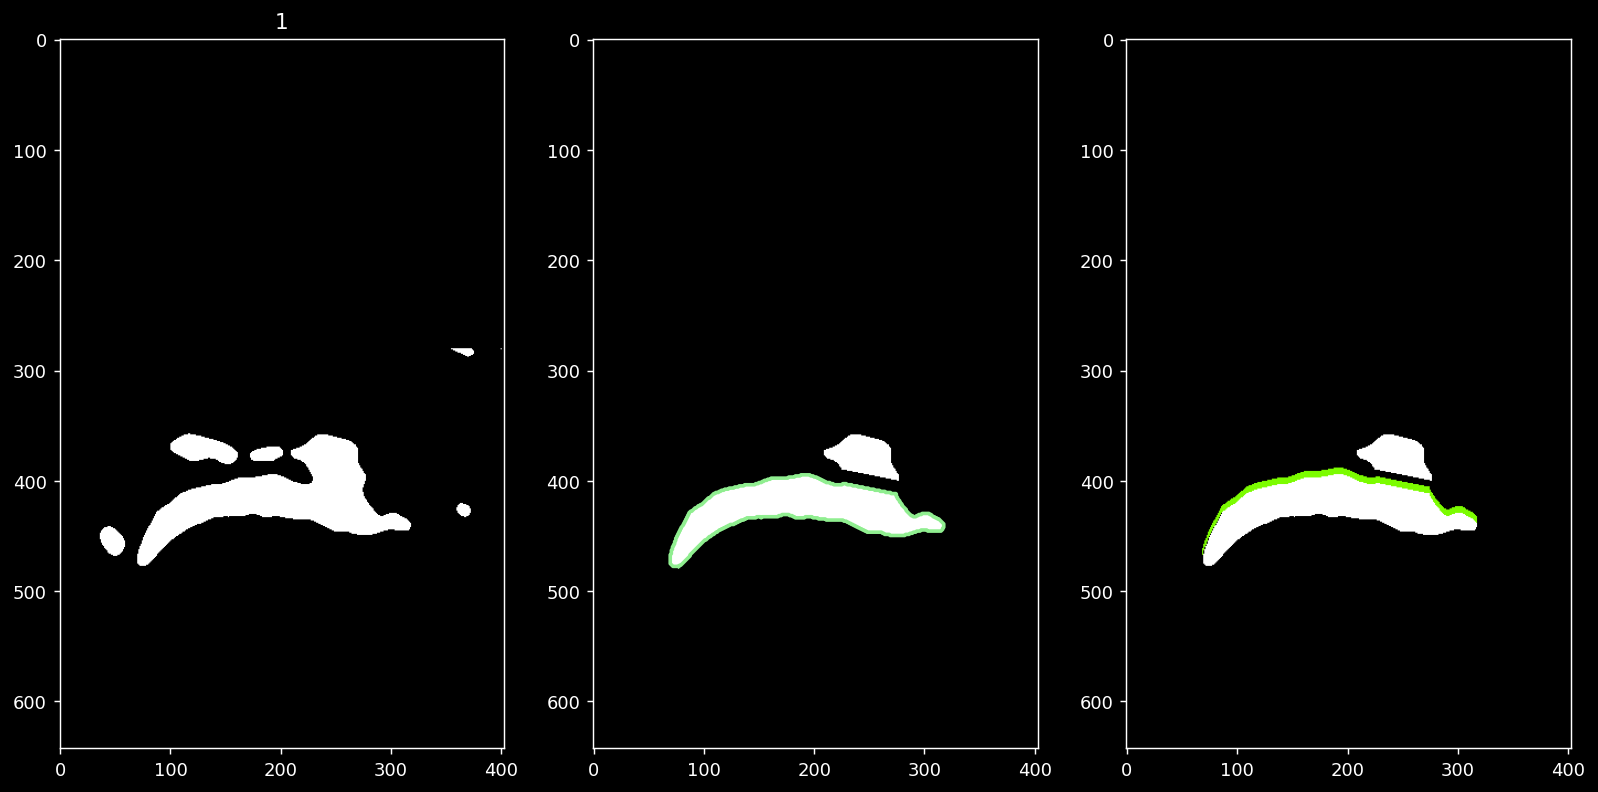

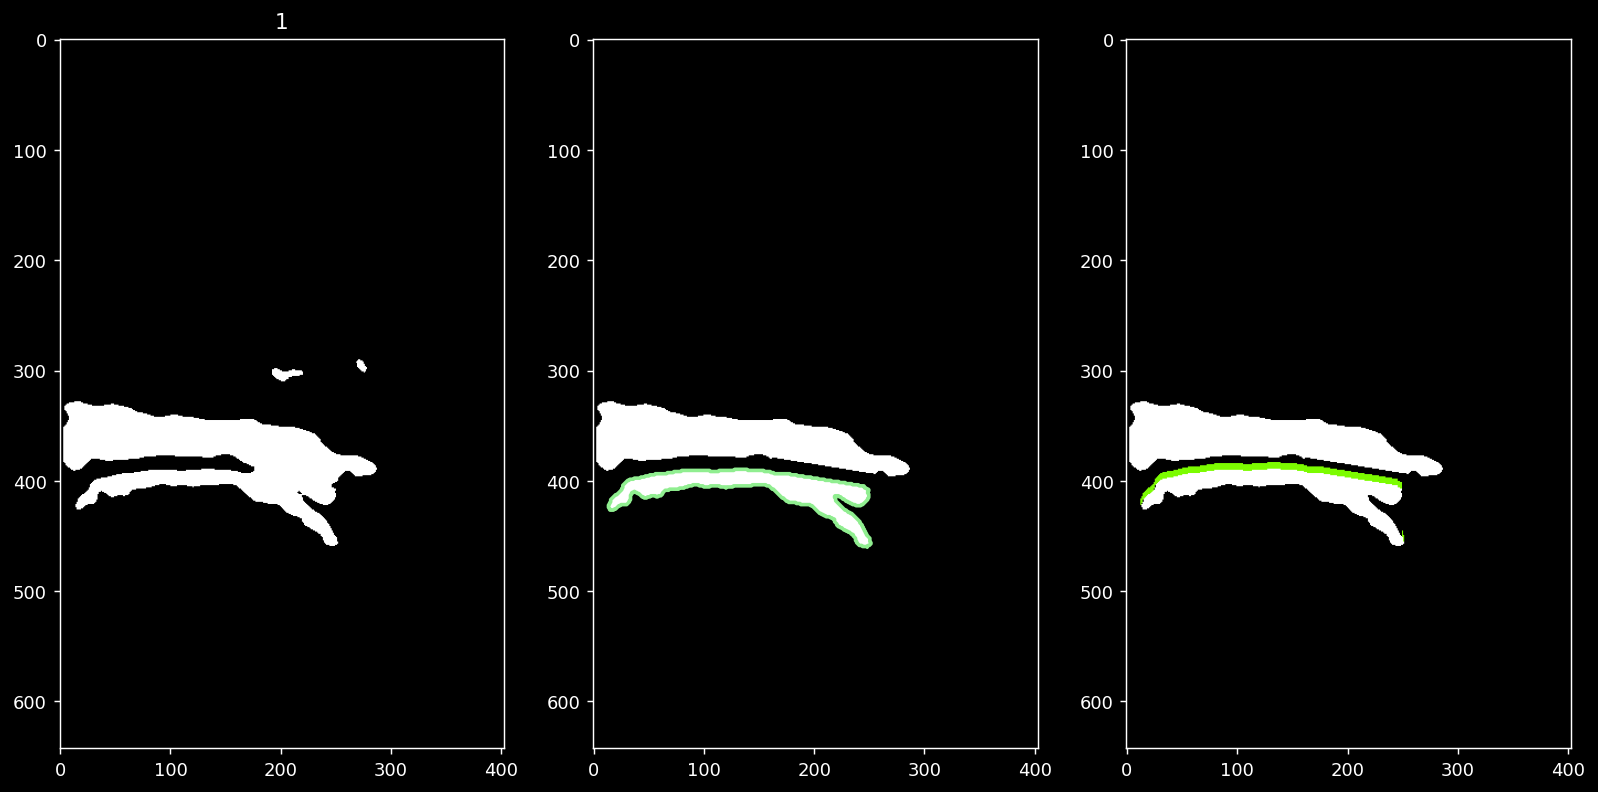

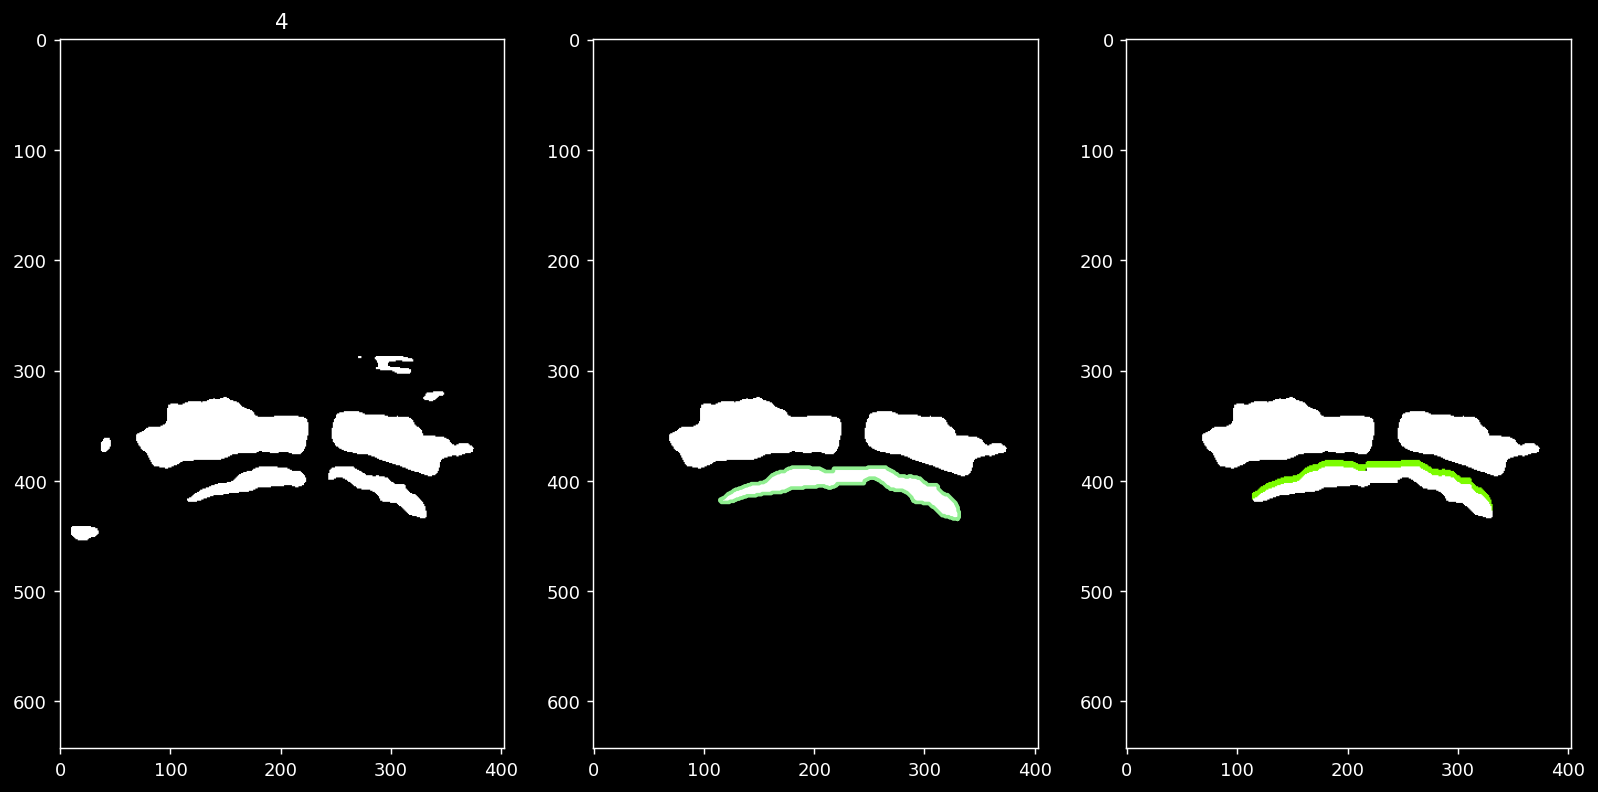

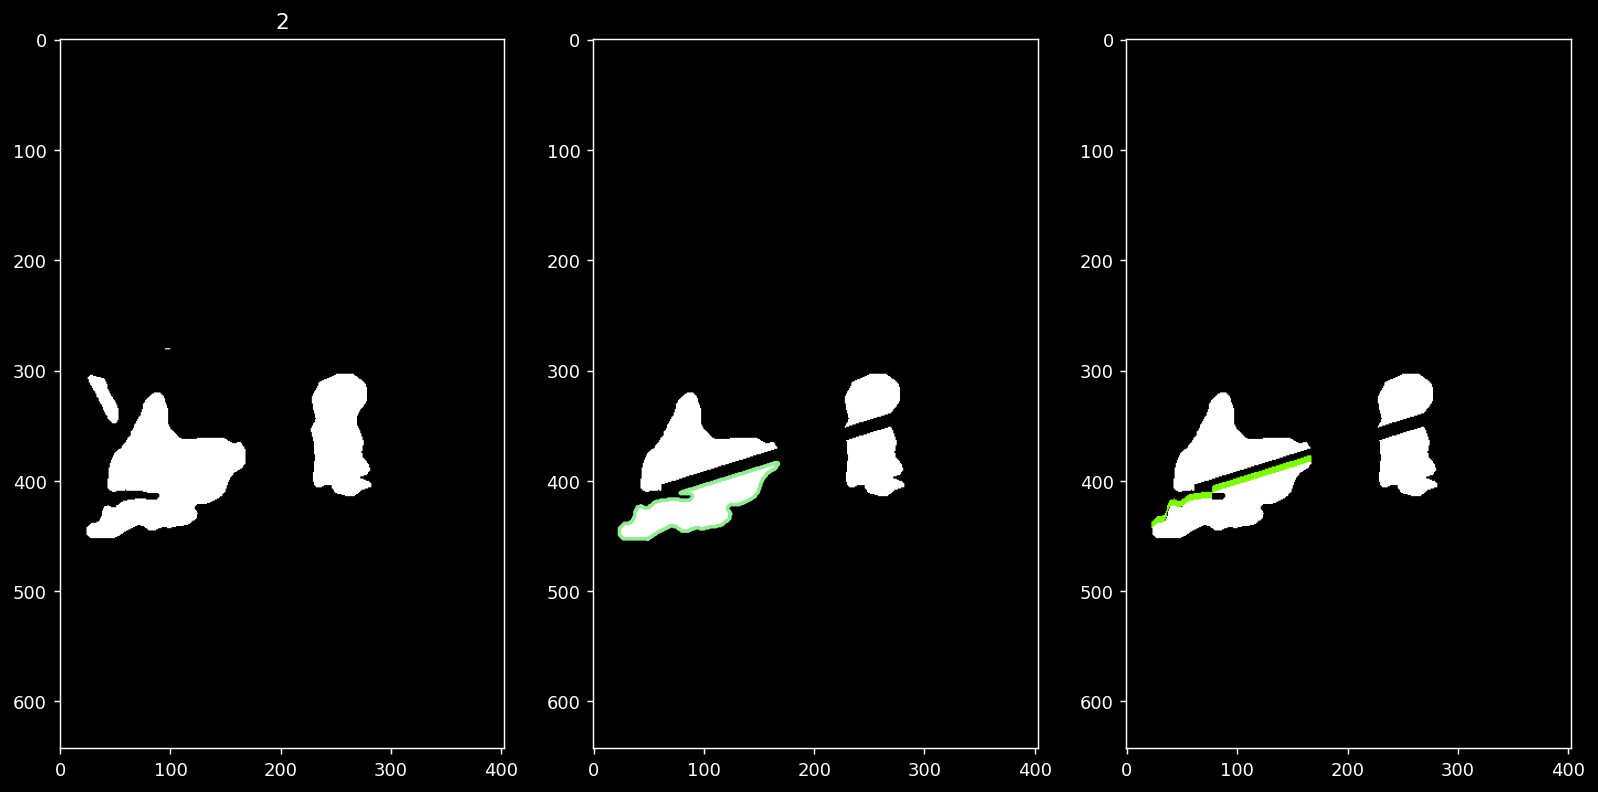

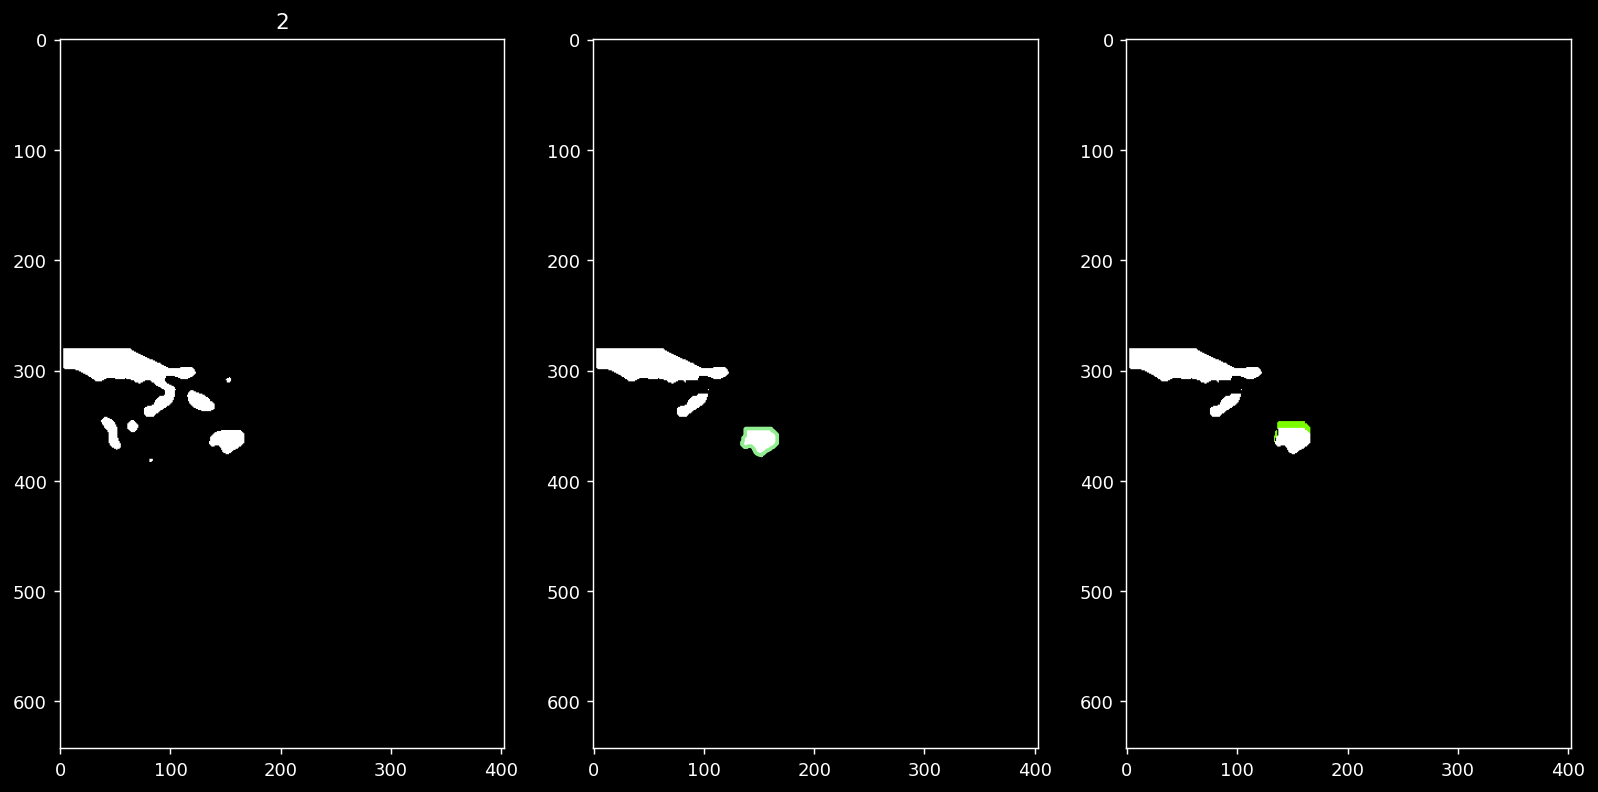

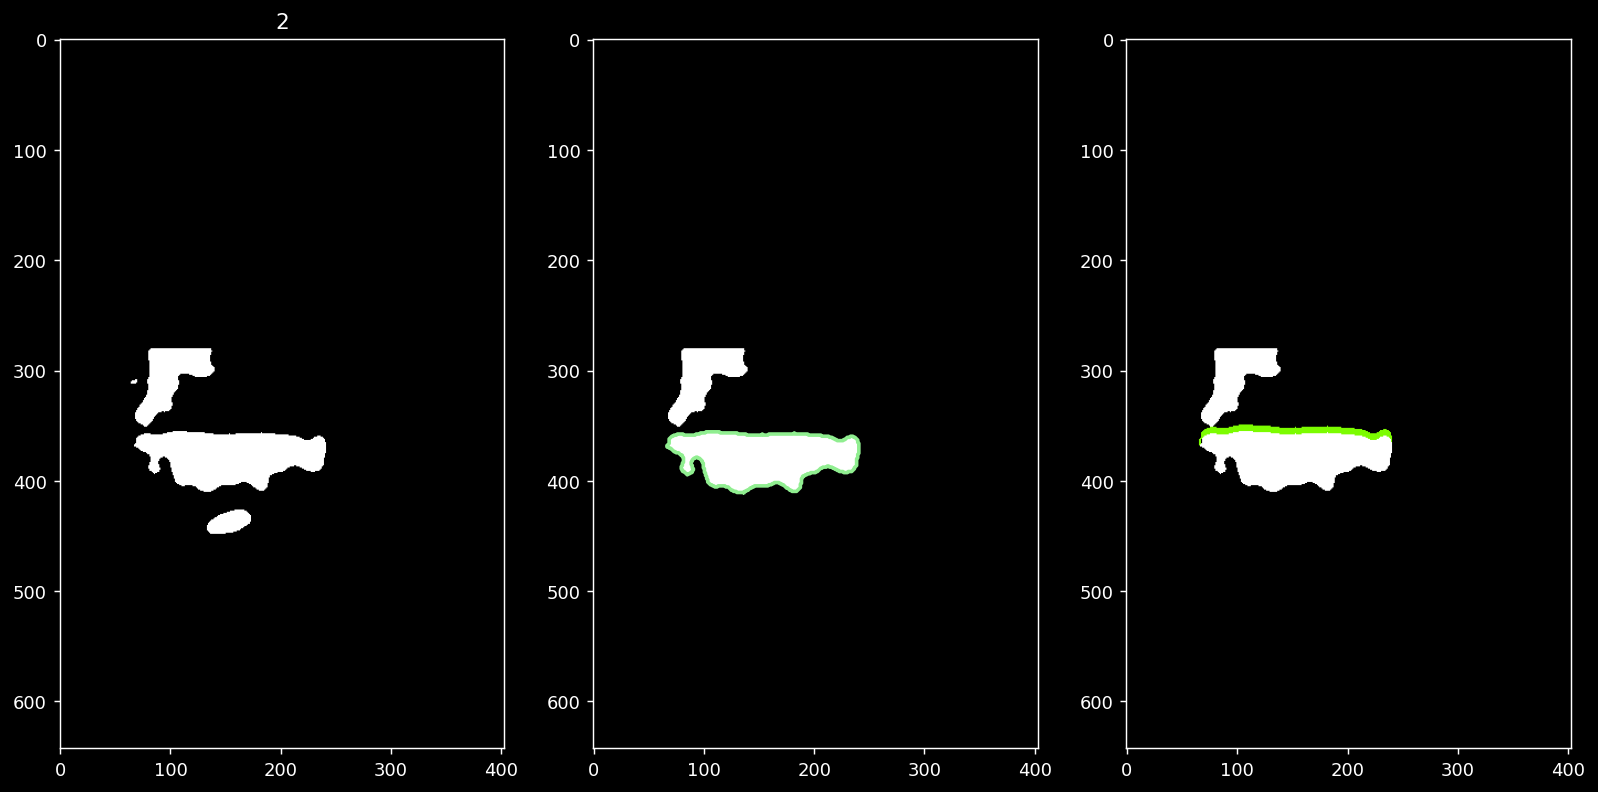

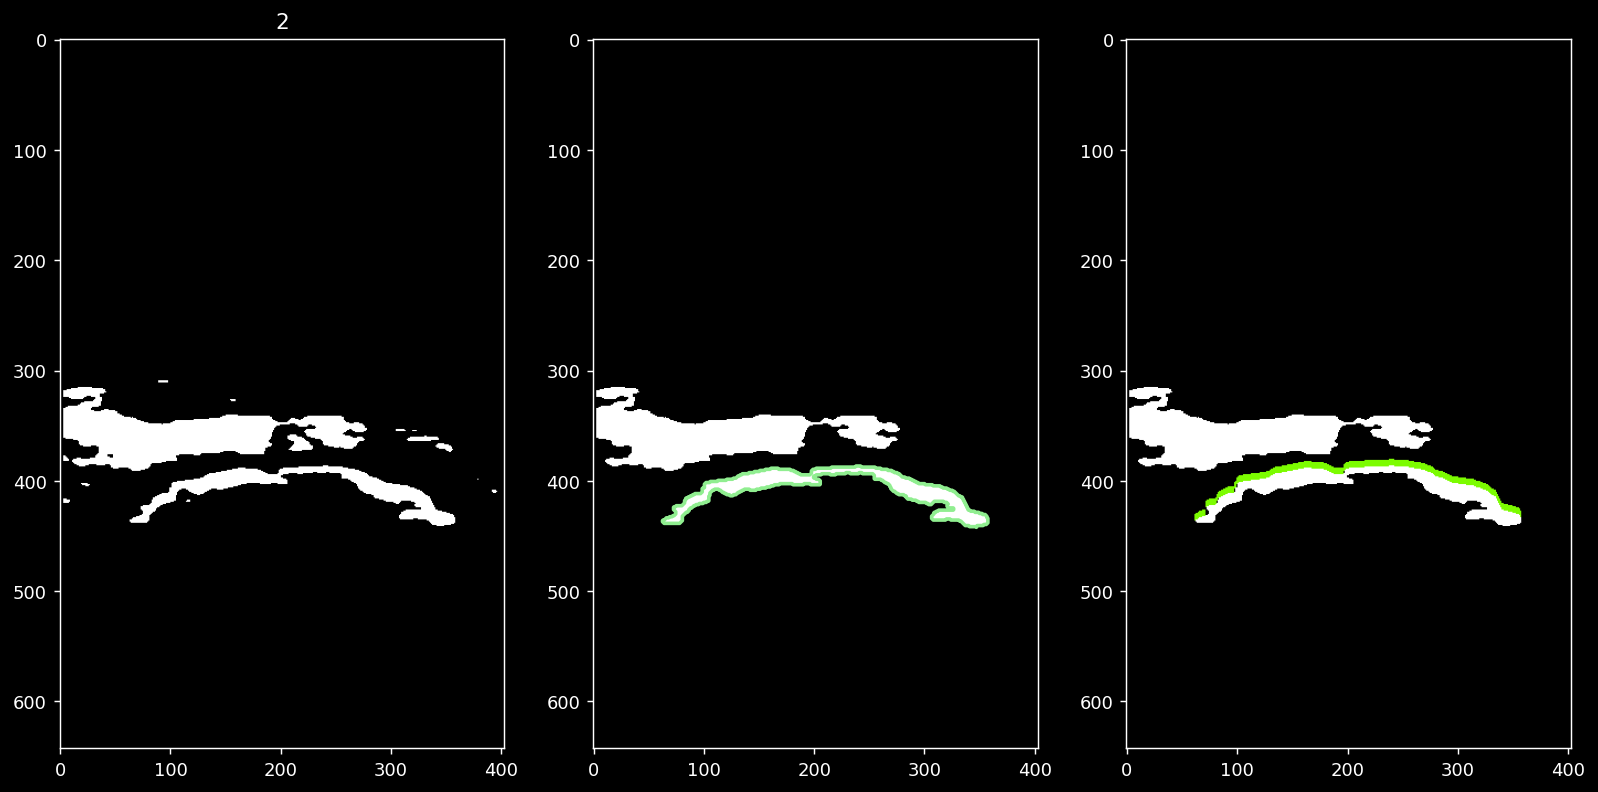

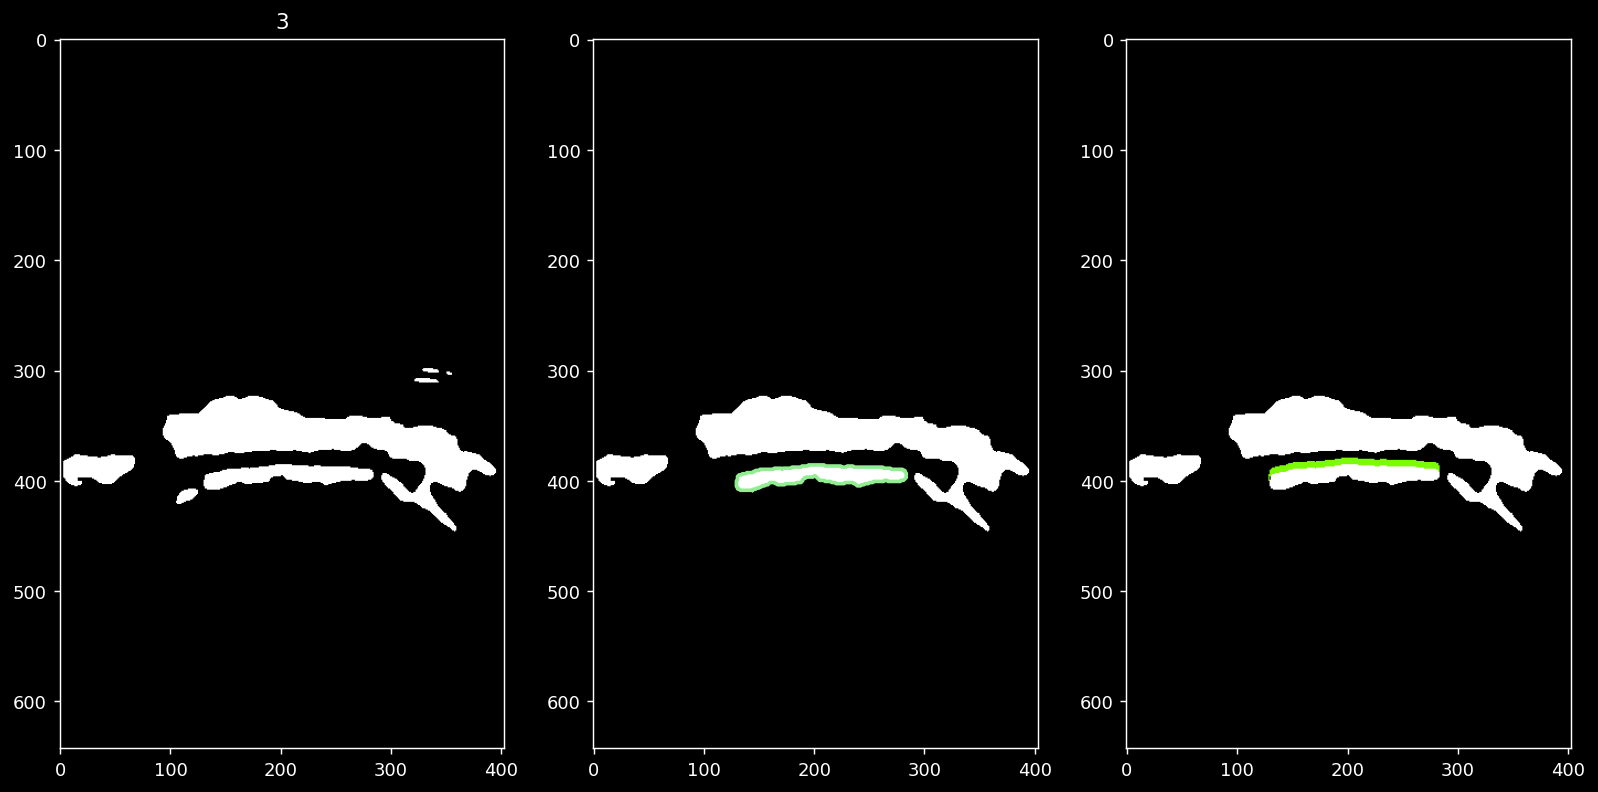

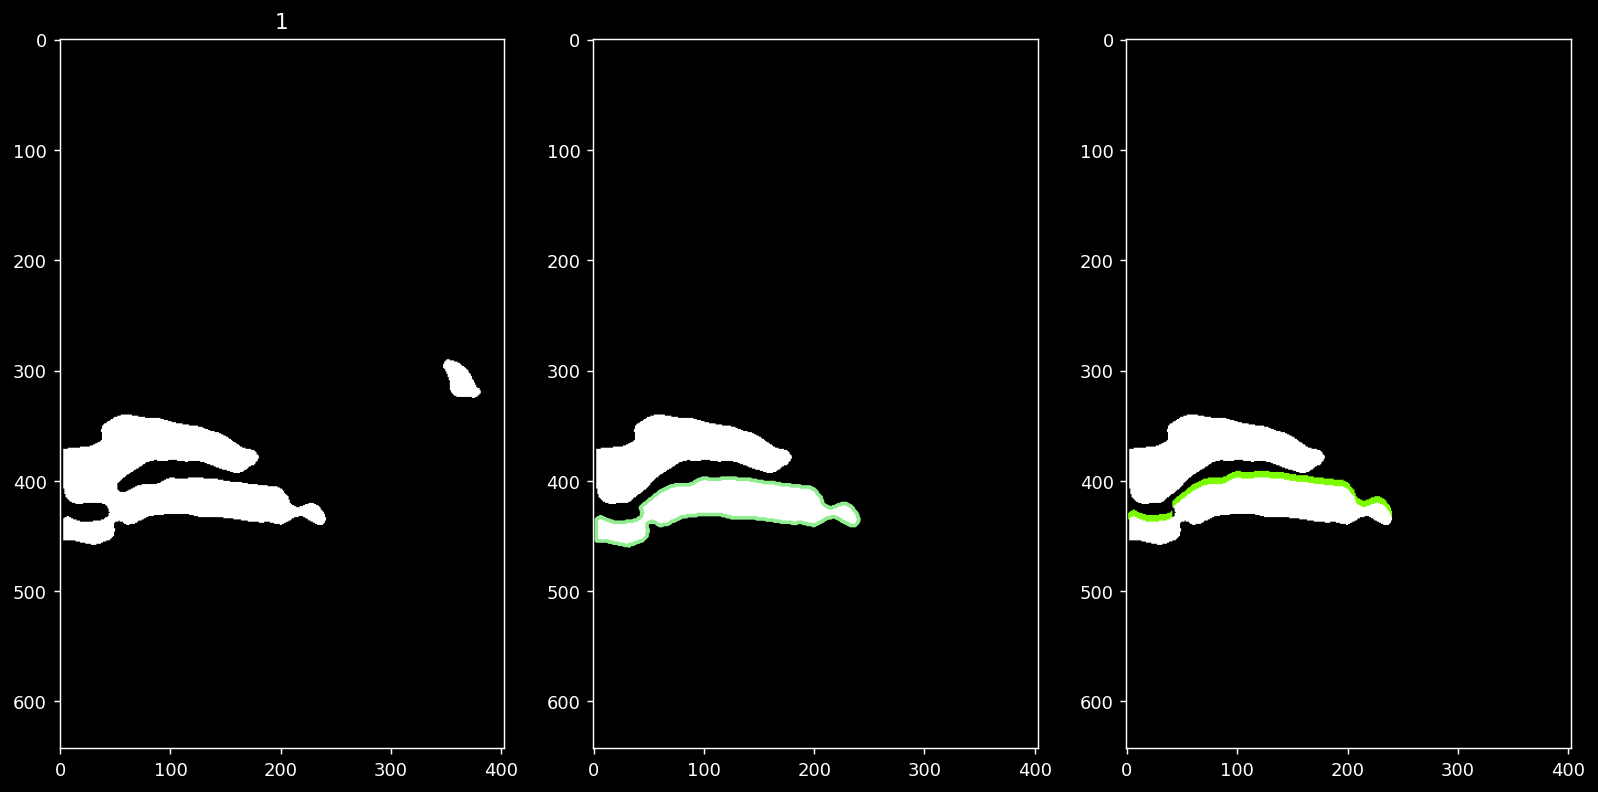

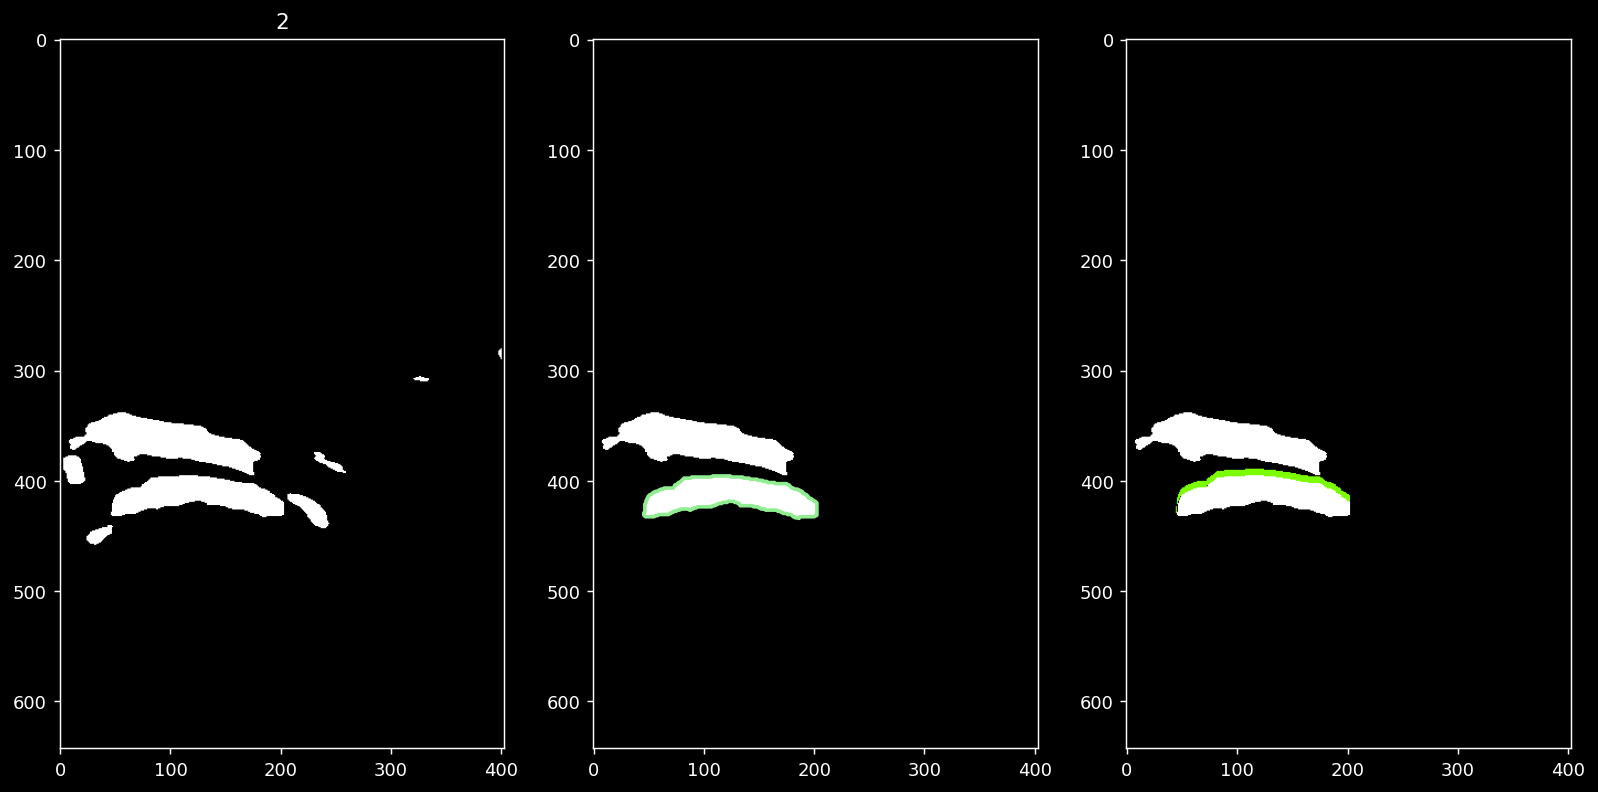

In [36]:
# iii = 0
# for i, bin in tqdm(enumerate(binimgs)):
#     if i < iii:
#         continue
#     postprocessor(bin, mask_height=6)
#     # break